In [76]:
import tensorflow as tf
import numpy as np
import collections
from math import ceil
import os
import nltk
import random
import math
import csv
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from matplotlib import pylab
import matplotlib.pyplot as plt

In [2]:
filename = 'processed_data.txt'

In [3]:
with open(filename, 'r') as f:
    words = f.readlines()

In [4]:
for index, word in enumerate(words):
    words[index] = word.rstrip()

In [5]:
words = " ".join(words)

In [6]:
def read_data(data_file):
    data = []
    print("READING DATA........")
    tokenized = nltk.word_tokenize(data_file)
    data.extend(tokenized)
    return data

words = read_data(words)
print('Data size %d' % len(words))
print('First 10 words: ', words[:10])
    

READING DATA........
Data size 6868221
First 10 words:  ['description', 'of', 'farmer', 'oak', 'an', 'incident', 'when', 'farmer', 'oak', 'smiled']


## Storing data in different manners
- dictionary: maps a word to an ID
- reverse_dictionary: maps an ID to a word
- count: stores the frequency of a word in a list of tuples
- data: stores the words as their IDs
 
This will help us in the future

In [7]:
vocabulary_size = 10000

def create_dataset(words):
    count = [['UNK', -1]]
    # we only choose the most frequently used words as our vocab rest will be replaced with UNK 
    # 'collections' will give us the most frequent words for a certain length
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    
    # mapping word to ID
    for word, _ in count:
        dictionary[word] = len(dictionary) # this will give IDs to all words as with each iteration 'len' increases
        
    # stores words as theirs IDs
    data = list()
    unk_count = 0
    
    for word in words:
        # If a word in dictionay then we use ID else it will be 'UNK'
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0 # id of UNK
            unk_count = unk_count + 1
        data.append(index)
    
    # total UNK in dataset
    count[0][1] = unk_count 

    # mapping ID to word
    # here we interchanged the positions, from (keys:values) to (values:keys)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    
    # making sure the dict is of the size of vocab
    assert len(dictionary) == vocabulary_size # this is like a checker if true then pass else raise AssertionError
    
    return data, count, dictionary, reverse_dictionary
    
data, count, dictionary, reverse_dictionary = create_dataset(words)
print('Data: ', data[:10])
print('Most common words: ' ,count[:10])


Data:  [0, 4, 162, 52, 42, 2138, 49, 162, 52, 1481]
Most common words:  [['UNK', 113980], ('the', 391991), ('and', 216126), ('a', 196601), ('of', 191339), ('to', 178043), ('in', 118910), ('i', 101234), ('was', 99654), ('it', 78347)]


## Creating Batches of Data for Skip-Gram
 
Here we produce a target word(batch) with its corresponding context words which we'll call labels. We'll read  2 * window_size + 1  words at a time (that's called a span) and create  2 * window_size  datapoints in a single span.

In [24]:
def create_batch(batch_size, window_size):
    span = 2 * window_size + 1
    batch = np.ndarray(shape=(batch_size), dtype = np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype = np.int32)
    label_id = []
    num_samples = 2*window_size 
    count = 0
    for i in range(batch_size - span + 1):
        sample = data[i:span+i]
        
        first_labels = sample[:window_size]
        last_labels = sample[-window_size:]
        
        label_id.extend(first_labels)
        label_id.extend(last_labels)
        
        if count < batch_size:
            for j in range(num_samples):
                batch[count] = sample[window_size]
                count += 1
                
    for j in range(batch_size):
        labels[j, 0] = label_id[j]
  
    return batch, labels

for window_size in [1, 2]:
    data_index = 0
    batch, labels = create_batch(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' %window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with window_size = 1:
    batch: ['of', 'of', 'farmer', 'farmer', 'oak', 'oak', 'an', 'an']
    labels: ['UNK', 'farmer', 'of', 'oak', 'farmer', 'an', 'oak', 'incident']

with window_size = 2:
    batch: ['farmer', 'farmer', 'farmer', 'farmer', 'oak', 'oak', 'oak', 'oak']
    labels: ['UNK', 'of', 'oak', 'an', 'of', 'farmer', 'an', 'incident']


## Skip-Gram

 
### Define Hyperparamereters
 
Here we will define the batch_size(number of samples in a single batch), embedding_size(size of embedding vectors), window_size(size of context window)

In [60]:
batch_size = 128
embedding_size = 128 
window_size = 4


Here we take a random validation set to sample nearest neighbors and we sample valid datapoints randomly from a large window without always being deterministic 

In [61]:
valid_size = 16
valid_window = 50

# we select the most frequent ones as well as moderately rare words
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples, random.sample(range(1000, 1000 + valid_window), valid_size), axis = 0)

num_sampled = 32 # Number of negative examples to sample

### Inputs and outputs
 
Here we provide the inputs and outputs to the model via placeholders ( each of size = batch_size) and a constant tensor to contain the validation examples

In [62]:
tf.reset_default_graph()

# input data (target_word)
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
# output data (context word)
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# validation data (no need of a placeholder as we already have defined the IDs of words selected for validation)
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

### Defineing model parameters and variables

In [63]:
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0,1.0))

# Softmax Weights and biases
softmax_weghts = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], 
                                                 stddev = 0.5 / math.sqrt(embedding_size)))
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size], 0.0,0.01))

### Model Computations
 
We define a lookup function that will fetch the corresponding embedding vectors for a given set of inputs and with that we define a negative sampling loss function, which takes in the embedding vectors and previously defined neural network parameters

In [64]:
embed = tf.nn.embedding_lookup(embeddings, train_dataset)

# loss function
loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(
        weights = softmax_weghts, biases = softmax_biases,
            inputs = embed, labels = train_labels, num_sampled = num_sampled,
            num_classes = vocabulary_size
        ))

### Word Similarities

To find the similarity between two given words we use the cosine distance between them.

In [65]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims = True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(
normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

### Optimizer

In [66]:
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

## Running the Algorithm

In [67]:
num_iterations = 100001
skip_losses = []

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    # initialize the variables
    tf.global_variables_initializer().run()
    print("Variables Initialized")
    average_loss = 0
    
    # running the iterations
    for i in range(num_iterations):
        
        # create batche of data
        batch_data, batch_labels = create_batch(batch_size, window_size)
        # fill the placeholders and run the optimizer 
        feed_dict = {train_dataset: batch_data, train_labels:batch_labels}
        
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # update the average loss
        average_loss += l
        
        if (i + 1) % 2000 == 0:
            if i > 0:
                average_loss = average_loss / 2000
                
            skip_losses.append(average_loss)
            
            # average_loss is an estimate of loss over the 2000 batches
            print('Average loss at iteration %d: %f' %(i + 1, average_loss))
            average_loss = 0
            
        # Evaluating validation set word similarities
        if (i + 1) % 10000 == 0:
            sim = similarity.eval()
            # We take top_k closesed words for a given validation word in terms of cosine dist
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 9 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s: ' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s, ' %(log, close_word)
                print(log)
    skip_gram_final_embeddings = normalized_embeddings.eval()
    
np.save('skip_embeddings_1', skip_gram_final_embeddings)

with open('skip_losses_1.csv' ,'wt') as f:
    writer = csv.writer(f, delimiter =',')
    writer.writerow(skip_losses)
                           

Variables Initialized
Average loss at iteration 2000: 0.336734
Average loss at iteration 4000: 0.282757
Average loss at iteration 6000: 0.281119
Average loss at iteration 8000: 0.268537
Average loss at iteration 10000: 0.278274
Nearest to said:  inspired,  speculative,  reflection,  floor,  watch,  moments,  spottedgrey,  gifted,  stank, 
Nearest to be:  halted,  pinch,  incorporeal,  drive,  eyelids,  decently,  harmony,  nightly,  conical, 
Nearest to a:  watermeadow,  deputing,  foreground,  mangled,  wakefulness,  prettily,  memorial,  banish,  oral, 
Nearest to upon:  inwardy,  recollect,  fine,  shillings,  frighten,  me,  spinning,  disputants,  repeated, 
Nearest to when:  needed,  edge,  s,  length,  shep,  waggoners,  darling,  shade,  arched, 
Nearest to with:  garish,  recipient,  hog,  strangled,  flame,  cloze,  hardly,  kicked,  stoop, 
Nearest to man:  introductoy,  click,  flexible,  carting,  silenus,  haze,  fistiness,  disagreeable,  cruelty, 
Nearest to is:  height

Average loss at iteration 52000: 0.250326
Average loss at iteration 54000: 0.256877
Average loss at iteration 56000: 0.255828
Average loss at iteration 58000: 0.245954
Average loss at iteration 60000: 0.242839
Nearest to said:  inspired,  speculative,  reflection,  floor,  watch,  moments,  spottedgrey,  gifted,  stank, 
Nearest to be:  halted,  pinch,  incorporeal,  drive,  eyelids,  decently,  harmony,  nightly,  conical, 
Nearest to a:  watermeadow,  deputing,  foreground,  mangled,  wakefulness,  prettily,  memorial,  banish,  oral, 
Nearest to upon:  inwardy,  recollect,  fine,  shillings,  frighten,  me,  spinning,  disputants,  repeated, 
Nearest to when:  shepherds,  loungers,  resonance,  s,  nobler,  tively,  twill,  grateful,  dur, 
Nearest to with:  garish,  recipient,  hog,  strangled,  flame,  cloze,  hardly,  kicked,  stoop, 
Nearest to man:  introductoy,  click,  flexible,  carting,  silenus,  haze,  fistiness,  disagreeable,  cruelty, 
Nearest to is:  heightened,  chri

## Visualization

Here we find only the closely clustered embeddings. This will get rid of more sparsly distributed word embeddings and will make the visualization clearer. This is useful for t-SNE visualization. We will also take 2 parameters,
 
- distance_threshold: max distance between two points to be called as neighbors
- sample_threshold: number of neighbors required to be considered a cluster

In [73]:
def find_clustered_embeddings(embeddings, distance_threshold, sample_threshold):
    
    cosine_similarity = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings ** 2, axis =1).reshape(-1,1), np.sum(np.transpose(embeddings) **2,
                                                                        axis = 0).reshape(1,-1))
    assert cosine_similarity.shape == norm.shape
    
    # make the diagonal entries zero else these will be picked as highest
    np.fill_diagonal(cosine_similarity, -1.0)
    argmax_cos_sim = np.argmax(cosine_similarity, axis = 1)
    mod_cos_sim = cosine_similarity
    
    # find the max values in a loop to count if there are more than n items 
    # above threshold
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_similarity, axis = 1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]), argmax_cos_sim] = -1
        
        max_cosine_sim = np.max(mod_cos_sim, axis=1)
        
        return np.where(max_cosine_sim > distance_threshold)[0]

## Computing t-SNE Visualization of Word Embeddings

In [74]:
num_points = 1000

tsne = TSNE(perplexity = 30, n_components = 2, init='pca', n_iter=5000)

print("Fitting embeddings to T-SNE")
selected_embeddings = skip_gram_final_embeddings[:num_points, :]
two_d_embeddings= tsne.fit_transform(selected_embeddings)

print("Pruning the T-SNE embeddings")

selected_ids = find_clustered_embeddings(selected_embeddings, 0.25,10)

two_d_embeddings = two_d_embeddings[selected_ids, :]

print('Out of ', num_points, ' samples. ', selected_ids.shape[0], 'Samples were selected by pruning')

Fitting embeddings to T-SNE
Pruning the T-SNE embeddings
Out of  1000  samples.  632 Samples were selected by pruning


### Plotting t-SNE Results 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

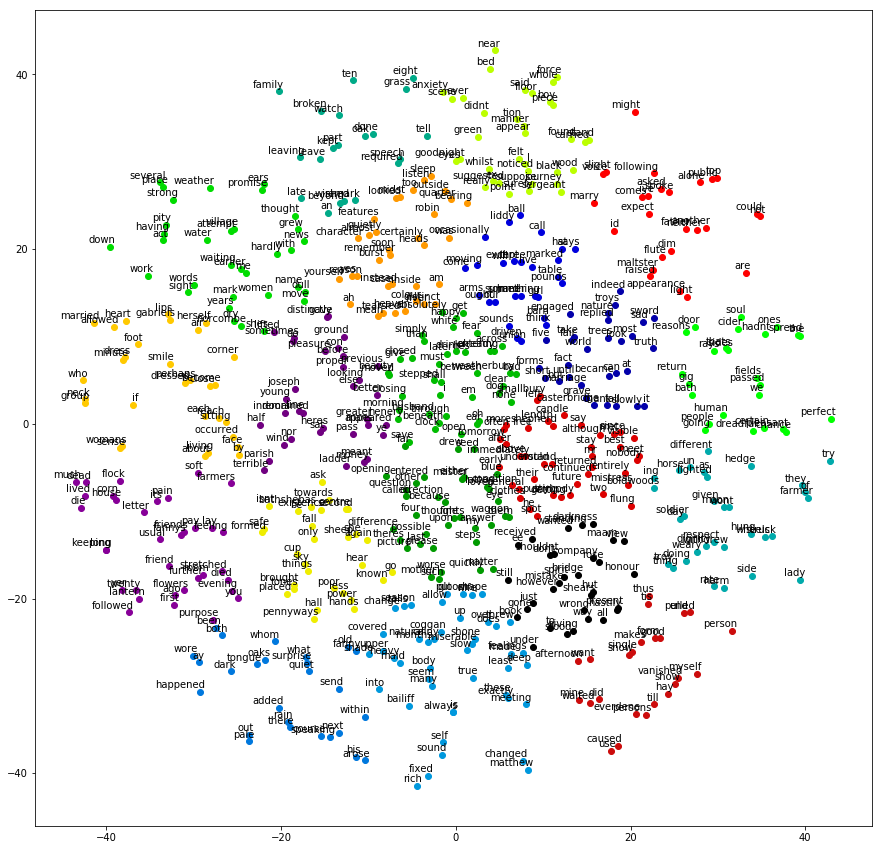

In [82]:
def plot(embeddings, labels):
    n_clusters = 20 
    label_colors = [pylab.cm.nipy_spectral(float(i) / n_clusters) for i in range(n_clusters)]
    
    assert embeddings.shape[0] >= len(labels), 'More Labels than embeddings'
    
    # Define K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state= 0).fit(embeddings)
    kmeans_labels = kmeans.labels_
    plt.figure(figsize=(15,15))
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        pylab.scatter(x, y, c=label_colors[klabel])    
        
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom',fontsize=10)
    pylab.show()
    
words = [reverse_dictionary[i] for i in selected_ids]
plot(two_d_embeddings, words)  